In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.applications import EfficientNetV2B0, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image


Malignant Samples from Training Data:


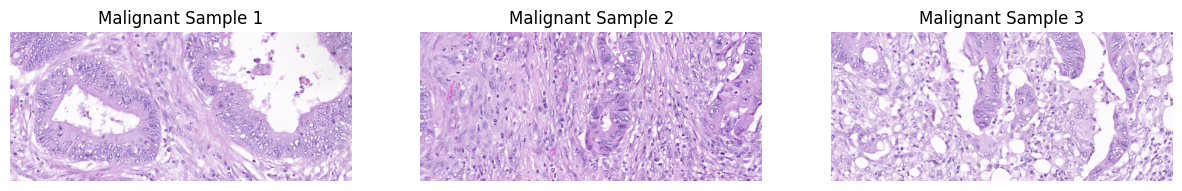

Benign Samples from Training Data:


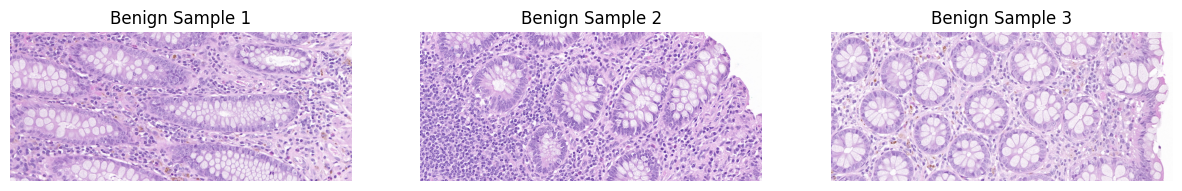

In [9]:

# Define paths
train_dir = '/content/drive/MyDrive/Thesis_Images/Train'
test_dir = '/content/drive/MyDrive/Thesis_Images/Test'

# Display sample images
def display_sample_images(category, image_folder, num_samples=3):
    folder_path = os.path.join(image_folder, category)
    images = os.listdir(folder_path)
    sample_images = random.sample(images, num_samples)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images, 1):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i)
        plt.imshow(img)
        plt.title(f'{category} Sample {i}')
        plt.axis('off')
    plt.show()

print("Malignant Samples from Training Data:")
display_sample_images('Malignant', train_dir)

print("Benign Samples from Training Data:")
display_sample_images('Benign', train_dir)


In [10]:

# Image data generators with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Prepare iterators
target_size = (224, 224)  # Resize images to 224x224

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# EfficientNetV2 model
efficientnetv2_base = EfficientNetV2B0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
efficientnetv2_base.trainable = True

efficientnetv2_model = tf.keras.Sequential([
    efficientnetv2_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))
])

efficientnetv2_model.compile(optimizer=optimizers.Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train EfficientNetV2 model with early stopping
history_efficientnetv2 = efficientnetv2_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
    ]
)


Found 1120 images belonging to 2 classes.
Found 280 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/20
35/35 [==============================] - 373s 10s/step - loss: 0.6756 - accuracy: 0.6143 - val_loss: 0.6651 - val_accuracy: 0.4964 - lr: 3.0000e-05
Epoch 2/20
35/35 [==============================] - 334s 10s/step - loss: 0.5408 - accuracy: 0.7937 - val_loss: 0.6960 - val_accuracy: 0.5036 - lr: 3.0000e-05
Epoch 3/20
35/35 [==============================] - 348s 10s/step - loss: 0.4237 - accuracy: 0.8777 - val_loss: 0.4806 - val_accuracy: 0.8429 - lr: 3.0000e-05
Epoch 4/20
35/35 [==============================] - 338s 10s/step - loss: 0.2976 - accuracy: 0.9339 - val_loss: 0.4864 - val_accuracy: 0.8643 - lr: 3.0000e-05
Epoch 5/20
35/35 [==============================] - 341s 10s/step - loss: 0.2018 - accuracy: 0.9509 - val_loss: 0.3129 - val_accuracy: 0.9321 - lr: 3.0000e-05
Epoch 6/20
35/35 [==============================] - 338s 10s/step - loss: 0.1360 

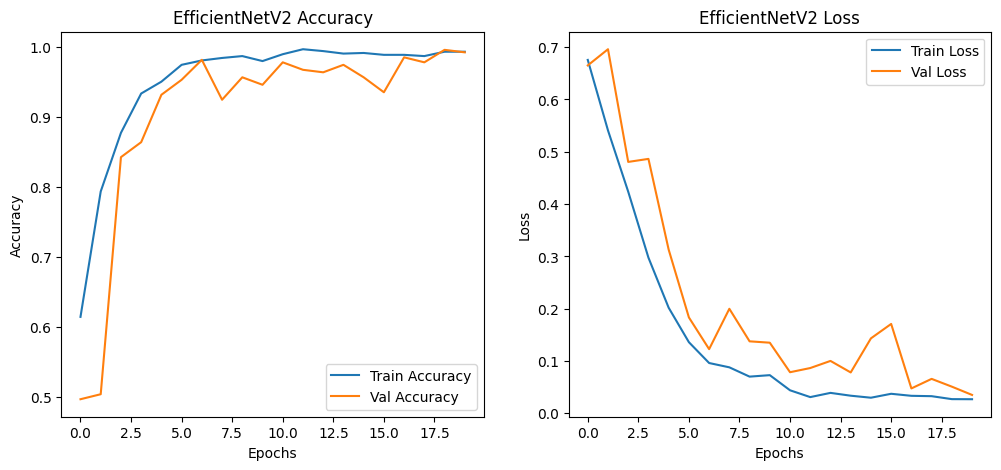

In [11]:

# Plot accuracy and loss graphs for EfficientNetV2
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_efficientnetv2.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnetv2.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetV2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_efficientnetv2.history['loss'], label='Train Loss')
plt.plot(history_efficientnetv2.history['val_loss'], label='Val Loss')
plt.title('EfficientNetV2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [12]:

# DenseNet model
densenet_base = DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
densenet_base.trainable = True

densenet_model = tf.keras.Sequential([
    densenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))
])

densenet_model.compile(optimizer=optimizers.Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train DenseNet model with  early stopping
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
    ]
)


29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/20
35/35 [==============================] - 1075s 29s/step - loss: 0.3719 - accuracy: 0.8277 - val_loss: 0.6431 - val_accuracy: 0.5393 - lr: 3.0000e-05
Epoch 2/20
35/35 [==============================] - 1026s 29s/step - loss: 0.0942 - accuracy: 0.9723 - val_loss: 0.4915 - val_accuracy: 0.6429 - lr: 3.0000e-05
Epoch 3/20
35/35 [==============================] - 1004s 29s/step - loss: 0.0416 - accuracy: 0.9893 - val_loss: 0.2804 - val_accuracy: 0.8500 - lr: 3.0000e-05
Epoch 4/20
35/35 [==============================] - 1010s 29s/step - loss: 0.0197 - accuracy: 0.9964 - val_loss: 0.1494 - val_accuracy: 0.9429 - lr: 3.0000e-05
Epoch 5/20
35/35 [==============================] - 991s 28s/step - loss: 0.0195 - accuracy: 0.9955 - val_loss: 0.0481 - val_accuracy: 0.9893 - lr: 3.0000e-05
Epoch 6/20
35/35 [==============================] - 1015s 29s/step - loss: 0.0156 - accuracy: 0.9982 - val_loss: 0.0300 - val_accuracy: 

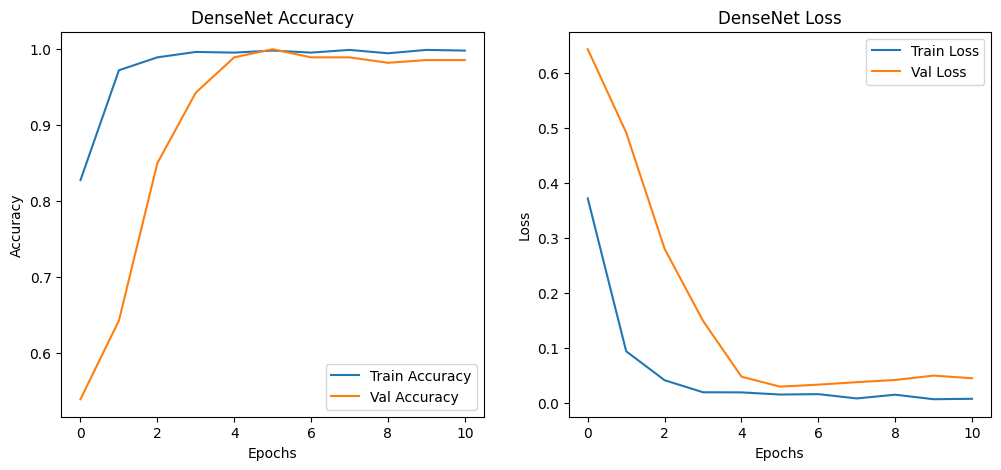

In [15]:

# Plot accuracy and loss graphs for DenseNet
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Val Accuracy')
plt.title('DenseNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['loss'], label='Train Loss')
plt.plot(history_densenet.history['val_loss'], label='Val Loss')
plt.title('DenseNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


19/19 [==============================] - 116s 6s/step
Ensemble model accuracy: 0.98


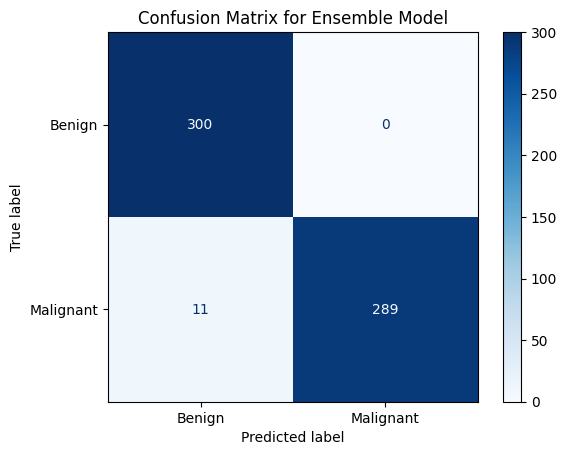

In [16]:

# Ensemble predictions
def ensemble_predict(models, generator):
    preds = [model.predict(generator) for model in models]
    avg_preds = np.mean(preds, axis=0)
    return np.round(avg_preds).flatten()

# List of models for ensemble
models = [efficientnetv2_model, densenet_model]

# Get predictions for test data
y_true = test_generator.classes
y_pred = ensemble_predict(models, test_generator)

# Evaluate the ensemble model
accuracy = accuracy_score(y_true, y_pred)
print(f'Ensemble model accuracy: {accuracy:.2f}')

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Ensemble Model')
plt.show()
